# Training AlexNet on CIFAR-10 dataset

We built the [AlexNet](https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf) model based on [this](https://towardsdatascience.com/implementing-alexnet-cnn-architecture-using-tensorflow-2-0-and-keras-2113e090ad98) tutorial (code available [here](https://github.com/RichmondAlake/tensorflow_2_tutorials/blob/master/015_alexnet.ipynb)).

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas as pd
from datetime import datetime

The following code cell below sets a fitting subdirectory for any logfiles created. Furthermore, it allows us to import our helper scripts and store the fit results independent of whether this notebook is executed in a locally cloned repository or in Google Colab (if we are in Colab, things get a bit more complicated unfortunately):

In [2]:
dataset_name = 'CIFAR-10'
classifier_name = 'AlexNet'

running_in_colab = 'google.colab' in str(get_ipython())
if running_in_colab:
  # unfortunately, we cannot import our helper scripts directly on Google Colab as other files from our repo are not accessible
  # we have to clone our GitHub repo to fetch the helper scripts and add the script folder of cloned repo to the syspath

  print('Notebook running on Google Colab')
  repo_path = './ml-ex3'
  repo_git_url = 'https://github.com/Sejmou/ml-ex3.git'

  import subprocess
  import sys

  def install(package):#https://stackoverflow.com/a/50255019/13727176
    print(f'Installing {package} using pip')
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])
  
  if 'git' not in sys.modules:
    install('GitPython')
  
  from git import Repo

  if os.path.exists(repo_path): # already cloned -> pull latest changes
    print('pulling from our git repo to get latest version of helper scripts')
    repo = Repo(repo_path)
    o = repo.remotes.origin
    o.pull()
    print('pulled successfully')
    sys.path.append(f'{repo_path}/notebooks')
    print('appended helper_scripts module to sys.path')
    import importlib
    import helper_scripts
    importlib.reload(helper_scripts)
    print('reloaded helper_scripts module')
  else:
    print('cloning our git repo to get helper scripts')
    Repo.clone_from(repo_git_url, repo_path)
    print('cloned successfully')
    sys.path.append(f'{repo_path}/notebooks')
    print('appended helper_scripts module to sys.path')

  from google.colab import drive
  drive.mount('/content/drive')
  
  drive_log_dir = '/content/drive/MyDrive/ml-ex3'# main folder where all logs and stuff are stored
  root_log_dir = f'{drive_log_dir}/{dataset_name}/{classifier_name}/{datetime.now().strftime("%Y-%m-%d_%H_%M_%S")}'#pick drive folder that suits you
  dataset_path = f'./data/{dataset_name}'
else:
  print('Notebook running locally') # in such cases there's not a lot we have to do fortunately :)
  root_log_dir = f'../model_fit_results/{dataset_name}/{classifier_name}/{datetime.now().strftime("%Y-%m-%d_%H_%M_%S")}'
  dataset_path = f'../data/{dataset_name}'
  

Notebook running locally


## Load data

For loading the data, we can use our custom `CIFAR10Loader` class.

In [3]:
from helper_scripts.data_loaders import CIFAR10Loader

In [4]:
data_loader = CIFAR10Loader(dataset_path)
X_train, X_val, X_test, y_train, y_val, y_test = data_loader.get_processed_imgs(target_width = 32, target_height = 32)# cannot resize to 257 directly, our implementation is too RAM-hungry

CIFAR-10 dataset already downloaded, loading files from memory
loading training images and labels
loading test images and labels
done
processing training images
processing test images
done processing, creating train/val/test split


Get a quick overview of the loaded data:

In [5]:
from helper_scripts.data_exploration import print_dataset_summary, show_img

print_dataset_summary(data=(X_train, X_val, X_test, y_train, y_val, y_test), dataset_name=dataset_name)


--- Checking loaded CIFAR-10 data ---
Data types
X_train: <class 'numpy.ndarray'>
X_val: <class 'numpy.ndarray'>
X_test: <class 'numpy.ndarray'>
y_train: <class 'numpy.ndarray'>
y_val: <class 'numpy.ndarray'>
y_test: <class 'numpy.ndarray'>

Data shapes
X_train: (35000, 32, 32, 3)
X_val: (15000, 32, 32, 3)
X_test: (10000, 32, 32, 3)
y_train: (35000,)
y_val: (15000,)
y_test: (10000,)

Image stats:
shape: (60000, 32, 32, 3)
Max value across all images and channels: 1.0
Min value across all images and channels: 0.0
Split sizes:
 train size: 35000
validation size: 15000
test size: 10000
Total dataset size: 60000

Train/Val/Test ratio: 0.58/0.25/0.17
Train/Val ratio:0.7/0.3
(Train+Val)/Test ratio:0.83/0.17


Let's look at an example image for each split:

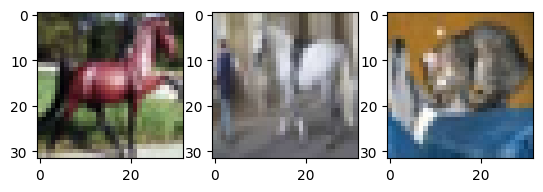

In [6]:
fig, ax = plt.subplots(1, 3)

for i, split in enumerate([X_train, X_val, X_test]):
  show_img(split[0], ax=ax[i], val_range_min=0, val_range_max=1)
  
plt.show()

How many classes are there?

In [7]:
NUM_CLASSES = data_loader.number_of_classes
NUM_CLASSES

10

What are the class labels?

In [8]:
labels = data_loader.text_label_dict
labels

{0: 'Airplane',
 1: 'Automobile',
 2: 'Bird',
 3: 'Cat',
 4: 'Deer',
 5: 'Dog',
 6: 'Frog',
 7: 'Horse',
 8: 'Ship',
 9: 'Truck'}

## Additional Data Preprocessing for AlexNet

To pass the images to AlexNet, we need to resize them to 227x227. As we have issues with the RAM-efficiency of our own image resize method, we didn't use the target size parameters of our dataloader and use TensorFlow instead:

In [9]:
IMG_WIDTH = IMG_HEIGHT = 257 # AlexNet expects images of size 257 x 257 as input

In [10]:
def resize_images(image, label):
    image = tf.image.resize(image, (IMG_WIDTH, IMG_HEIGHT))
    return image, label

In [11]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
validation_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))

import gc
# make sure we get rid of all unused memory; we need every little piece of RAM!
del X_train
del y_train
del X_test
del y_test
del X_val
del y_val
gc.collect()

10

In [12]:
train_ds_size = len(list(train_ds))
train_ds_size = len(list(test_ds))
validation_ds_size = len(list(validation_ds))

Now, let's resize our images and put them into batches:

In [13]:
train_ds = (train_ds
                  .map(resize_images)
                  .batch(batch_size=8, drop_remainder=True))

test_ds = (test_ds
                  .map(resize_images)
                  .batch(batch_size=8, drop_remainder=True))

validation_ds = (validation_ds
                  .map(resize_images)
                  .batch(batch_size=8, drop_remainder=True))

## Defining The Model

In [14]:
def create_AlexNet():
  return keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(IMG_WIDTH,IMG_HEIGHT,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(NUM_CLASSES, activation='softmax')
  ])

In [15]:
model = create_AlexNet()

In [17]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.SGD(learning_rate=0.001), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 30, 30, 256)      1024      
 hNormalization)                                                 
                                                        

### Adding callbacks

We will use three callbacks: one for storing the best model weights, one custom callback for measuring the fit time, and one for logging the training process to TensorBoard.

In [18]:
from keras.callbacks import ModelCheckpoint

log_dir = os.path.join(root_log_dir, 'no_augmentation')

checkpoint_path = os.path.join(log_dir, 'best_val_acc_weights.h5')
checkpoint_cb = ModelCheckpoint(filepath=checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)

In [20]:
from helper_scripts.deep_learning import TimeHistory
time_cb = TimeHistory()

In [21]:
from keras.callbacks import TensorBoard

tensorboard_cb = TensorBoard(os.path.join(log_dir, 'tensorboard'))

## Fitting the Model

In [22]:
epochs = 50

history = model.fit(train_ds,
          epochs=epochs,
          validation_data=validation_ds,
          validation_freq=1,
          callbacks=[checkpoint_cb, time_cb, tensorboard_cb])

Epoch 1/50
4375/4375 [==============================] - ETA: 0s - loss: 1.9809 - accuracy: 0.3485
Epoch 1: val_accuracy improved from -inf to 0.48367, saving model to ../model_fit_results/CIFAR-10/AlexNet/2022-02-21_12_48_22/no_augmentation/best_val_acc_weights.h5
4375/4375 [==============================] - 148s 33ms/step - loss: 1.9809 - accuracy: 0.3485 - val_loss: 1.4260 - val_accuracy: 0.4837
Epoch 2/50
4375/4375 [==============================] - ETA: 0s - loss: 1.5194 - accuracy: 0.4543
Epoch 2: val_accuracy improved from 0.48367 to 0.53447, saving model to ../model_fit_results/CIFAR-10/AlexNet/2022-02-21_12_48_22/no_augmentation/best_val_acc_weights.h5
4375/4375 [==============================] - 144s 33ms/step - loss: 1.5194 - accuracy: 0.4543 - val_loss: 1.3013 - val_accuracy: 0.5345
Epoch 3/50
4375/4375 [==============================] - ETA: 0s - loss: 1.3640 - accuracy: 0.5131
Epoch 3: val_accuracy improved from 0.53447 to 0.57440, saving model to ../model_fit_results/CIFA

4374/4375 [============================>.] - ETA: 0s - loss: 0.1691 - accuracy: 0.9425
Epoch 22: val_accuracy improved from 0.75240 to 0.75993, saving model to ../model_fit_results/CIFAR-10/AlexNet/2022-02-21_12_48_22/no_augmentation/best_val_acc_weights.h5
4375/4375 [==============================] - 142s 33ms/step - loss: 0.1691 - accuracy: 0.9425 - val_loss: 0.8653 - val_accuracy: 0.7599
Epoch 23/50
4375/4375 [==============================] - ETA: 0s - loss: 0.1473 - accuracy: 0.9510
Epoch 23: val_accuracy did not improve from 0.75993
4375/4375 [==============================] - 147s 34ms/step - loss: 0.1473 - accuracy: 0.9510 - val_loss: 0.9120 - val_accuracy: 0.7565
Epoch 24/50
4375/4375 [==============================] - ETA: 0s - loss: 0.1327 - accuracy: 0.9564
Epoch 24: val_accuracy improved from 0.75993 to 0.76327, saving model to ../model_fit_results/CIFAR-10/AlexNet/2022-02-21_12_48_22/no_augmentation/best_val_acc_weights.h5
4375/4375 [==============================] - 144s

4375/4375 [==============================] - ETA: 0s - loss: 0.0246 - accuracy: 0.9926
Epoch 47: val_accuracy did not improve from 0.77560
4375/4375 [==============================] - 141s 32ms/step - loss: 0.0246 - accuracy: 0.9926 - val_loss: 1.1567 - val_accuracy: 0.7731
Epoch 48/50
4375/4375 [==============================] - ETA: 0s - loss: 0.0239 - accuracy: 0.9932
Epoch 48: val_accuracy did not improve from 0.77560
4375/4375 [==============================] - 141s 32ms/step - loss: 0.0239 - accuracy: 0.9932 - val_loss: 1.1591 - val_accuracy: 0.7705
Epoch 49/50
4375/4375 [==============================] - ETA: 0s - loss: 0.0243 - accuracy: 0.9925
Epoch 49: val_accuracy did not improve from 0.77560
4375/4375 [==============================] - 141s 32ms/step - loss: 0.0243 - accuracy: 0.9925 - val_loss: 1.1966 - val_accuracy: 0.7681
Epoch 50/50
4375/4375 [==============================] - ETA: 0s - loss: 0.0231 - accuracy: 0.9931
Epoch 50: val_accuracy did not improve from 0.77560


In [23]:
import time

time_cb.save_fit_times_csv(os.path.join(log_dir, 'fit_times.csv'))
print(f'Total fit time was {time.strftime("%H:%M:%S", time.gmtime(time_cb.total_fit_time))}')

Total fit time was 01:58:30


We are done with fitting the model! Let's quickly load the optimal weights and save that optimal model:

In [25]:
# load optimal model
model.load_weights(checkpoint_path)
# save it
model.save(os.path.join(log_dir, 'Model.h5'))

scores = model.evaluate(test_ds, verbose=1)

1250/1250 [==============================] - 12s 10ms/step - loss: 1.1417 - accuracy: 0.7727


We managed to achieve a test set accuracy of approximately 77%, the prediction took around 12 seconds.

Let's look at how loss and accuracy developed over the epochs:

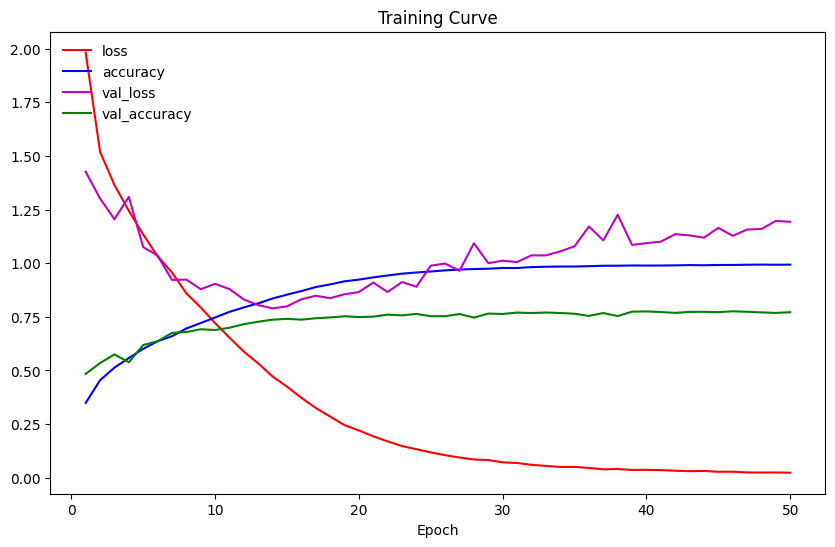

In [27]:
from helper_scripts.deep_learning import plot_loss_and_acc

plot_loss_and_acc(history.history, epochs)

## Fitting model on augmented data

Can we improve our classifier by using data augmentation? Let's find out!

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
    )

train_ds_np = np.stack(list(train_ds))
#datagen.fit(train_ds)# this doesn't work with BatchDataset as input, therefore we needed to convert
train_ds_np

We create a new AlexNet model:

In [ ]:
aug_model = create_AlexNet()
aug_model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.SGD(learning_rate=0.001), metrics=['accuracy'])
aug_model.summary()

Define new callbacks:

In [ ]:
log_dir = os.path.join(root_log_dir, 'with_augmentation')

checkpoint_path = os.path.join(log_dir, 'best_val_acc_weights.h5')
checkpoint_cb = ModelCheckpoint(filepath=checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)

In [ ]:
time_cb = TimeHistory()

In [ ]:
tensorboard_cb = TensorBoard(os.path.join(log_dir, 'tensorboard'))

In [ ]:
history = aug_model.fit(datagen.flow(train_ds, batch_size=batch_size),
                    validation_data=datagen.flow(X_val.reshape(*X_val.shape, 1), y_val, batch_size=batch_size),
                    workers=4,
                    epochs=epochs, callbacks=[checkpoint_cb, time_cb, tensorboard_cb])

history = model.fit(train_ds,
          epochs=epochs,
          validation_data=validation_ds,
          validation_freq=1,
          callbacks=[checkpoint_cb, time_cb, tensorboard_cb])

In [ ]:
time_cb.save_fit_times_csv(os.path.join(log_dir, 'fit_times.csv'))
print(f'Total fit time was {time.strftime("%H:%M:%S", time.gmtime(time_cb.total_fit_time))}')

We are done with fitting the "augmented" model! Let's also load the optimal weights and save that optimal model. Then, look at the test set accuracy:

In [ ]:
# load optimal model
aug_model.load_weights(checkpoint_path)
# save it
aug_model.save(os.path.join(log_dir, 'Model.h5'))

scores = aug_model.evaluate(test_ds, verbose=1)

Let's look at how loss and accuracy developed over the epochs:

In [ ]:
from helper_scripts.deep_learning import plot_loss_and_acc

plot_loss_and_acc(history.history, epochs)

## Evaluation on test data

In [ ]:
pred_start = time.time()
model.evaluate(test_ds)
prediction_time = time.time() - pred_start
print(f'Prediction took {prediction_time} seconds')

Let's look at the results in detail:

In [ ]:
y_preds = model.predict(test_ds)# matrix; row: observation, col: prob. for class
y_pred = np.argmax(y_preds, axis=1)

In [ ]:
y_pred.shape

In [ ]:
y_test = np.concatenate([y for x, y in test_ds], axis=0)

In [ ]:
y_test.shape

In [ ]:
print('Test Data accuracy(%): ', accuracy_score(y_test, y_pred)*100)

In [ ]:
cf = confusion_matrix(y_test, y_pred)

In [ ]:
# mapping of numeric label to text label
text_labels = { 0:'Airplane',
            1:'Automobile', 
            2:'Bird', 
            3:'Cat', 
            4:'Deer', 
            5:'Dog', 
            6:'Frog', 
            7:'Horse', 
            8:'Ship', 
            9:'Truck'}

In [ ]:
keys, values = zip(*text_labels.items())
df_cm = pd.DataFrame(cf, index = values,  columns = values)
plt.figure(figsize = (16,12))
sns.heatmap(df_cm, annot=True, fmt='g')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred, labels=keys, target_names=values))